# Utilised code from https://www.kaggle.com/harshsoni/ranzcr-simple-densenet121-approach to build this model

## *REMEMBER TO CHANGE RUNTIME TO GPU*

# Imports
Imports and Installations

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pip install tensorflow_addons -q
# pip install tensorflow-gpu -q
# pip install pathlib

Note: you may need to restart the kernel to use updated packages.


In [16]:
# inbuilt imports
import os
import glob
import pathlib
import tempfile
import functools

# numeric imports
import numpy as np
import pandas as pd

# visual imports
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# modeling imports
import tensorflow as tf
import tensorflow_addons as tfa

import pathlib

In [15]:
%cd C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-catheter-line-classification

C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-catheter-line-classification


In [13]:
%matplotlib inline
sns.set()

Define paths for image training later

In [34]:
train_path = pathlib.Path('C:\\Users\\Johnn\\Desktop\\ADS2002\\ranzcr-clip-catheter-line-classification\\train')
test_path = pathlib.Path('C:\\Users\\Johnn\\Desktop\\ADS2002\\ranzcr-clip-catheter-line-classification\\test')

Define constants

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 16

all_labels = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 
              'NGT - Abnormal', 'NGT - Borderline','NGT - Incompletely Imaged', 
              'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 
              'Swan Ganz Catheter Present']

# Define dataframes

`train` provides one hot encoding for labelling. 

`train_coord` gives class counts and coordinates for catheters

In [20]:
df = pd.read_csv("train.csv")
df_coord = pd.read_csv("train_annotations.csv")

df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [21]:
df_coord.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


## Data Paths
Add the paths of images to the dataframe for easy access


In [35]:
df['path'] = df['StudyInstanceUID'].map(lambda x: str(train_path/(x+'.jpg')))
df.iloc[0][-1]

'C:\\Users\\Johnn\\Desktop\\ADS2002\\ranzcr-clip-catheter-line-classification\\train\\1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'

In [37]:
df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,path
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...


# EDA


## Classes

Data suggests an imbalance for each class.

In [23]:
data = df.loc[:, all_labels].sum().sort_values()
dist = pd.DataFrame({'Class': data.index, 'Pos': data.values}, columns=['Class', 'Pos'])
dist

,Class,Pos
0,ETT - Abnormal,79
1,NGT - Abnormal,279
2,NGT - Borderline,529
3,Swan Ganz Catheter Present,830
4,ETT - Borderline,1138
5,NGT - Incompletely Imaged,2748
6,CVC - Abnormal,3195
7,NGT - Normal,4797
8,ETT - Normal,7240
9,CVC - Borderline,8460


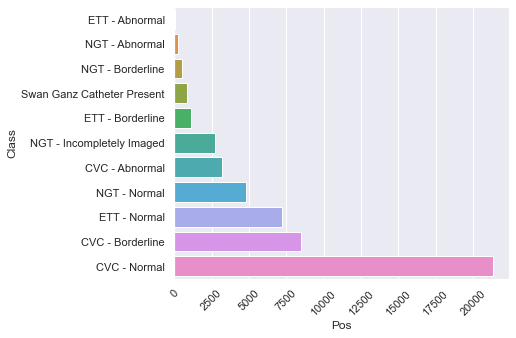

In [24]:
fig = plt.figure(figsize=(6, 5))

sns.barplot(data=dist, y='Class', x='Pos')
plt.xticks(rotation=45)
plt.show()

In [25]:
dist['Neg'] = len(df) - dist.Pos
dist.sort_values(by='Pos')

,Class,Pos,Neg
0,ETT - Abnormal,79,30004
1,NGT - Abnormal,279,29804
2,NGT - Borderline,529,29554
3,Swan Ganz Catheter Present,830,29253
4,ETT - Borderline,1138,28945
5,NGT - Incompletely Imaged,2748,27335
6,CVC - Abnormal,3195,26888
7,NGT - Normal,4797,25286
8,ETT - Normal,7240,22843
9,CVC - Borderline,8460,21623


## `PatientID`

Given that `PatientID` is a possible variable, it suggests a one to many relationship between one patient and many detections/data points.

In [26]:
print(len(df))
print(len(df.PatientID.unique()))

30083
3255


In [27]:
grouped_df = df.set_index('PatientID')
grouped_df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,path
PatientID,,,,,,,,,,,,,
ec89415d1,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
bf4c6da3c,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
3fc1c97e5,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
c31019814,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
207685cd1,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...


In [28]:
grouped_df.loc['ec89415d1'].sort_values(by=['StudyInstanceUID'])

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,path
PatientID,,,,,,,,,,,,,
ec89415d1,1.2.826.0.1.3680043.8.498.12069601668869166279...,0,0,0,0,0,1,0,0,0,1,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
ec89415d1,1.2.826.0.1.3680043.8.498.13669042249425506984...,0,0,0,0,0,0,1,0,1,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
ec89415d1,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
ec89415d1,1.2.826.0.1.3680043.8.498.34482941866634300538...,0,0,0,0,0,0,0,1,0,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
ec89415d1,1.2.826.0.1.3680043.8.498.58735051192792195566...,0,0,0,0,0,0,0,0,1,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
ec89415d1,1.2.826.0.1.3680043.8.498.76602365606870209106...,0,0,0,0,1,0,0,0,1,0,0,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...


As the dataframe above suggests, there exists multiple records for a single patient.

Hence, when selecting the images for training and validation, patients of the same ID need to be kept within their distinct splits. Otherwise data leakage occurs, and the model provide outputs without learning, due to already prelearning the output. 

Thus, for training/validation split, must group on `PatientID` and split accordingly.

# Splitting Data

In [38]:
grouped_df = df.groupby('PatientID')
train_list = [group for _, group in grouped_df]

`train_list` is a list of dataframes for each patient.

`train_list[0]` gives dataframe for `PatientID` - 003e65ddb

In [39]:
def train_valid_splitter(d, train_size=0.8):
    n = len(d)
    trains = d[:int(train_size*n)]
    valids = d[int(train_size*n):]
    return trains, valids

train_split, valid_split = train_valid_splitter(train_list)
train_df = pd.concat(train_split, axis=0)
valid_df = pd.concat(valid_split, axis=0)

print(f'Train Size: {len(train_df)}, Valid Size: {len(valid_df)}')

Train Size: 24100, Valid Size: 5983


In [40]:
train_df

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,path
15388,1.2.826.0.1.3680043.8.498.59892784756152007438...,0,0,0,0,0,0,0,1,0,0,0,003e65ddb,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
26606,1.2.826.0.1.3680043.8.498.99288640270596999784...,0,0,0,0,0,0,0,0,0,1,0,003e65ddb,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
26736,1.2.826.0.1.3680043.8.498.24106277096191278042...,0,0,0,0,0,0,0,1,0,0,0,003e65ddb,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
11171,1.2.826.0.1.3680043.8.498.48867760618674148489...,0,0,0,0,0,0,0,0,1,0,0,00757839e,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
16045,1.2.826.0.1.3680043.8.498.42161315615619527946...,0,0,0,0,0,0,0,0,0,1,0,00757839e,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1.2.826.0.1.3680043.8.498.35342516979031910596...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
6027,1.2.826.0.1.3680043.8.498.29151406117761819957...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
15510,1.2.826.0.1.3680043.8.498.10464763505639233965...,0,0,0,0,0,0,0,0,1,0,0,cff48b351,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...
26603,1.2.826.0.1.3680043.8.498.12245783950654018071...,0,0,0,0,0,0,0,0,0,1,0,cff48b351,C:\Users\Johnn\Desktop\ADS2002\ranzcr-clip-cat...


# Create Data Generators

Using `ImagDataGenerator`, we can build the inital pipeline of the model.

Image transforms include horizontally flipping and rotating (by 0.4 radians, just a randomly chosen number).

In [41]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=0.40
)

train_datagen = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col=all_labels,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='raw'
)

Found 24100 validated image filenames.


In [42]:
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_datagen = valid_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col=all_labels,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='raw'
)

Found 5983 validated image filenames.


In [43]:
def display_batch(batch, n_imgs=9):
    r = int(n_imgs**0.5)
    fig, axs = plt.subplots(r, r, figsize=(12, 15))
    imgs, labels = batch[0], batch[1]
    for i, ax in zip(range(n_imgs), axs.flatten()):
        title = '\n'.join(list(np.array(all_labels)[labels[i].flatten()==1]))
        ax.imshow(imgs[i], cmap='bone')
        ax.set_title(title)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

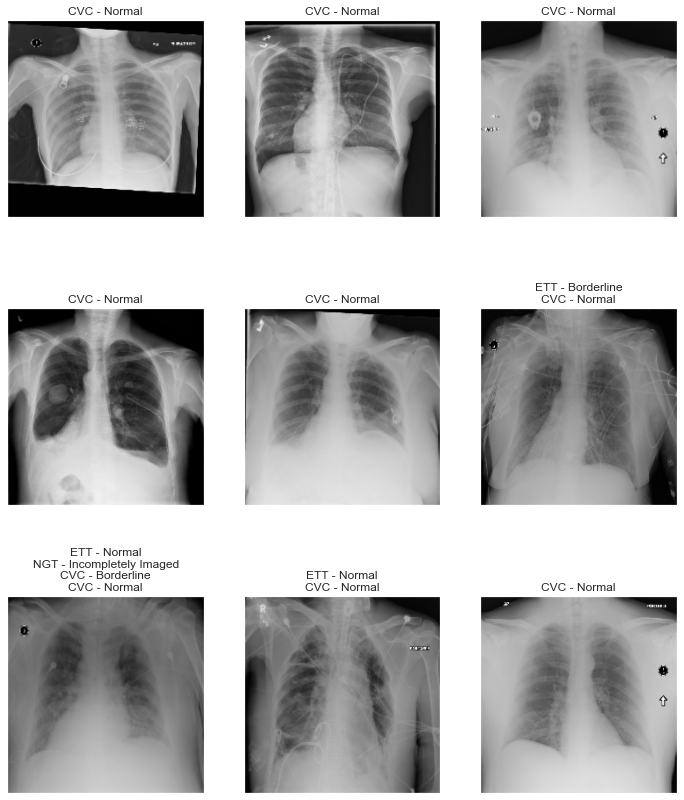

In [44]:
display_batch(next(train_datagen))

# Model Building

In [45]:
pip install image-classifiers -q

Note: you may need to restart the kernel to use updated packages.


In [24]:
from classification_models.tfkeras import Classifiers

ResNet18, proc_func = Classifiers.get('resnet18')

In [46]:
densenet = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
densenet.trainable = False

inputs = densenet.inputs
x = densenet(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(all_labels), activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

29097984/29084464 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11275     
Total params: 7,048,779
Trainable params: 11,275
Non-trainable params: 7,037,504
_________________________________________________________________


# Learning Rate
Build a learning rate finder to find an optimal lr for finetuning the model.

In [47]:
class LRFinder:
    def __init__(self, model, lr_range=[1e-10, 1e1], beta=0.98, stop_factor=4):
        self.model = model
        self.lr_range = lr_range
        self.beta = beta
        self.stop_factor = stop_factor
        self.stop_training = False
        self.iterations = 0
        self.mvg_avg_loss = 0
        self.min_loss = 1e9
        self.lrs = []
        self.losses = []

    def _reset(self):
        self.stop_training = False
        self.iterations = 0
        self.mvg_avg_loss = 0
        self.min_loss = 1e9
        self.lrs = []
        self.losses = []

    def _scheduler(self, start_lr, end_lr, iterations):
        self.lr_factor = (end_lr / start_lr)**(1./iterations)

    def on_train_begin(self, logs=None):
        self._reset()

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1

        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr*self.lr_factor)

        loss = logs['loss']
        self.mvg_avg_loss = (self.beta*self.mvg_avg_loss) + ((1-self.beta)*loss)
        smooth_loss = self.mvg_avg_loss / (1-(self.beta**self.iterations))
        self.losses.append(smooth_loss)

        stop_loss = self.stop_factor * self.min_loss
        if self.iterations > 1 and smooth_loss > self.stop_factor:
            self.stop_training = True

        if self.iterations == 0 or smooth_loss < self.min_loss:
            self.min_loss = smooth_loss
#         print(f'\nIterations: {self.iterations}, lr: {lr}, loss: {smooth_loss}/{loss}, lrf: {self.lr_factor}')

    def on_epoch_end(self, epoch, logs=None):
        if self.stop_training:
            self.model.stop_training = True
            return

    def find(self, train_ds, epochs=None, steps_per_epoch=None, batch_size=32):
        if epochs is None:
            raise ValueError(f'Invalid value {epochs} for epochs')

        if steps_per_epoch is None:
            steps_per_epoch = len(train_ds)
            
        self._scheduler(self.lr_range[0], self.lr_range[1], steps_per_epoch*epochs)

        with tempfile.NamedTemporaryFile(prefix='init', suffix='.h5') as init_config:
            # save model config
            self.model.save_weights(init_config.name)
            init_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            
            tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_range[0])

            lr_finder_cb = tf.keras.callbacks.LambdaCallback(
                on_train_begin= lambda logs: self.on_train_begin(logs),
                on_batch_end= lambda batch, logs: self.on_batch_end(batch, logs),
                on_epoch_end= lambda epoch, logs: self.on_epoch_end(epoch, logs)
            )

            self.model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                           callbacks=[lr_finder_cb])

            # restore model config
            tf.keras.backend.set_value(self.model.optimizer.lr, init_lr)
            self.model.load_weights(init_config.name)

    def plot_loss(self, skip_begin=10, skip_end=1, title=""):
        lrs = self.lrs[skip_begin:-skip_end]
        losses = self.losses[skip_begin:-skip_end]
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")

Compute lr

In [ ]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_accuracy', tf.keras.metrics.AUC()])

# lr_finder = LRFinder(model)
# lr_finder.find(train_datagen, epochs=10)

For our CLR we can use a minimum learning rate of 1e-2 and a maximum learning rate of 1e-5.

`CyclicalLearningRate` provided by tensorflow_addons library, keep the initial learning rate to 1e-5 and the maximum learning rate to be 1e-2 and use a 'traingular' approach of CLR. 

We are keeping the step size = 2 epochs. Hence, to perform 1 cycle we will need to perform 4 epochs.

In [48]:
def scale_fn(x):  return 1.

In [49]:
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-5,
    maximal_learning_rate=1e-2,
    scale_fn=scale_fn,
    step_size=2*len(train_datagen)*BATCH_SIZE,
    scale_mode='cyclic'
)

To evaluate our model we will use 'binary_accuracy' and 'AUROC Score', as our model itself will be evaluated on the AUROC score.

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC()])

In [51]:
model.fit(train_datagen, epochs=4, batch_size=BATCH_SIZE, 
          steps_per_epoch=len(train_datagen), 
          validation_data=valid_datagen,
          validation_steps=len(valid_datagen))

Epoch 1/4
1507/1507 [==============================] - 4515s 3s/step - loss: 0.3678 - binary_accuracy: 0.8354 - auc: 0.8157 - val_loss: 0.2649 - val_binary_accuracy: 0.8880 - val_auc: 0.8987
Epoch 2/4
1507/1507 [==============================] - 5097s 3s/step - loss: 0.2630 - binary_accuracy: 0.8912 - auc: 0.9042 - val_loss: 0.2573 - val_binary_accuracy: 0.8896 - val_auc: 0.9082
Epoch 3/4
1507/1507 [==============================] - 7378s 5s/step - loss: 0.2560 - binary_accuracy: 0.8923 - auc: 0.9107 - val_loss: 0.2537 - val_binary_accuracy: 0.8904 - val_auc: 0.9111
Epoch 4/4
1507/1507 [==============================] - 5360s 4s/step - loss: 0.2523 - binary_accuracy: 0.8931 - auc: 0.9139 - val_loss: 0.2498 - val_binary_accuracy: 0.8912 - val_auc: 0.9130


In [52]:
model.save("model_1")

INFO:tensorflow:Assets written to: model_1\assets


   Now, we unfreze the model and finetune the entire model.

In [54]:
densenet.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                11275     
Total params: 7,048,779
Trainable params: 6,965,131
Non-trainable params: 83,648
_________________________________________________________________


In [55]:
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-5, #before: 1e-9
    maximal_learning_rate=1e-2, #before: 1e-4
    scale_fn=scale_fn,
    step_size=2*len(train_datagen)*BATCH_SIZE,
    scale_mode='cyclic'
)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC()])

In [57]:
model.fit(train_datagen, epochs=4, batch_size=BATCH_SIZE, 
          steps_per_epoch=len(train_datagen), 
          validation_data=valid_datagen,
          validation_steps=len(valid_datagen))

Epoch 1/4
 379/1507 [======>.......................] - ETA: 38:27:31 - loss: 0.2642 - binary_accuracy: 0.8905 - auc_1: 0.9044

KeyboardInterrupt: 